In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
# %load_ext nb_black
# black formatter for jupyter lab
%load_ext lab_black

%run ../../src/notebook_env.py


---------------------------------
Working on the host: imarevic-pc

---------------------------------
Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]

---------------------------------
Python interpreter: /home/imarevic/Documents/teaching/SRH/content/statistik/statistik-env/bin/python3


# Entscheidungsbäume

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler
import dtreeviz

In Kapitel 8 hatten wir die lineare Regression und die polynomiale Regression, als Verfahren zur Vorhersage kontinuierlicher Variablen kennen gelernt. Für die Vorhersage kategorialer Variablen wurde in Kapitel 9 die logistische Regression dargestellt. Im Folgenden werden wir ein Verfahren kennenlernen, das sowohl für Regressions- als auch Klassifikationsprobleme verwenden werden kann, die Entscheidungsbäume.

<a href="https://de.wikipedia.org/wiki/Entscheidungsbaum">Entscheidungsbäume</a> sind baumbasierte Verfahren, die sowohl für Regressions-, als auch Klassifikationsprobleme genutzt werden können. Hierbei wir der Vorhersageraum in eine bestimmte Anzahl Regionen **segmentiert** und kann somit als Baumstruktur visualisiert werden ({cite:t}`James2013` s.303–314).

## Regressions-Bäume

Um Entscheidungsbäume besser zu verstehen, wenden wir uns zunächst dem Fall der Regression zu und behandeln **Regressions-Bäume**. Als Beispiel verwenden wir einen fiktiven Datensatz indem Einkommensdaten gelistet sind. Wir werden versuchen das Einkommen (`income`) anhand der Variablen Anzahl Jahre in der Schule (`education`) und Berufserfahrung (`seniority`) vorherzusagen. Zunächst laden wir den Datensatz:

In [3]:
df = pd.read_csv("../../data/income_data.csv")

Eine kurze Visualisierung der Daten zeigt, dass ein Zusammenhang zwischen `income` und den beiden Prädiktoren `education` und `seniority` besteht, wobei der Zusammenhang für `education` etwas stärker ist als für `seniority`:

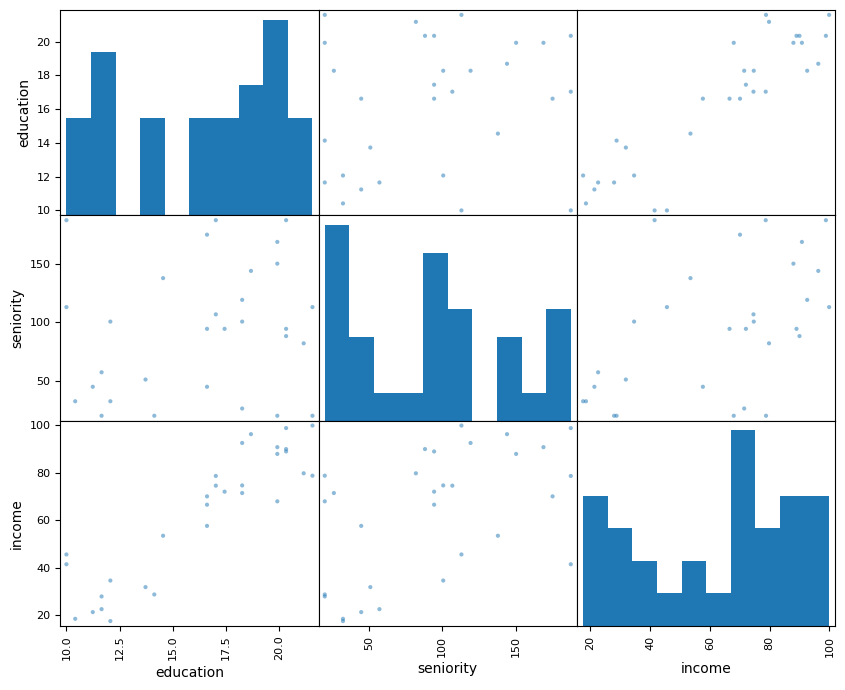

In [4]:
pd.plotting.scatter_matrix(df, figsize=(10, 8))
plt.show()

Wir greifen nun etwas voraus und fitten einen einfachen Entscheidungsbaum, unter Nutzung der Bibliothel `scikit-learn`, an die Daten und visualisieren den Baum anhand der Splits (hierfür verwenden wir die Bibliothek `dtreeviz`), die für die Variablen `education` und `seniority` im Entscheidungsbaum angewendet wurden. Hier zunächst die Visualisierung:

/home/imarevic/Documents/teaching/SRH/content/statistik/statistik-env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


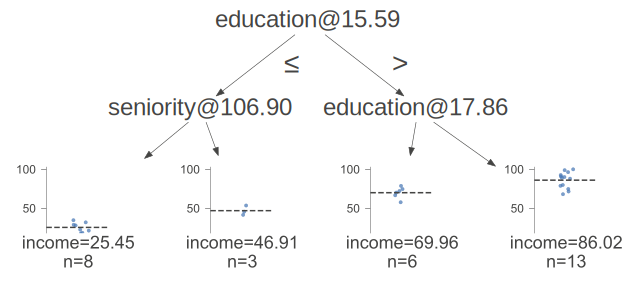

In [5]:
# fit a regression tree in order to create
# the regressor object
features = ["education", "seniority"]
target = "income"
X = df[features]
y = df[target]
reg = DecisionTreeRegressor(max_leaf_nodes=4, max_depth=2)
model = reg.fit(X, y)
# create viz model object
viz_model = dtreeviz.model(
    reg,
    X_train=df[features],
    y_train=df[target],
    feature_names=features,
    target_name=target,
)
# plot view
viz_model.view(fancy=False, scale=2)

In der erzeugten Visualisierung ist schön zu sehen, dass der Entscheidungsbaum zur Vorhersage des Einkommens bei einer Tiefe von 2 den ersten Split bei 15.59 Jahren in Bezug auf die Anzahl Jahre in der Schule einführt. Eine Ebene darunter wird dann auf Basis der selben Variablen bei 17.86 Jahren, sowie bei einer Seniority von 106.90 gesplittet. Der in jedem "Blatt" des Baumes angezeigte Wert gibt das mittlere Einkommen für die Beobachtungen an, die zu dem jeweiligen Blatt gehören.

Verallgemeinert lässt sich also festhalten, dass in einem Entscheidungsbaum die Ergebnisse eines Splits für Prädiktoren $X_{j}$ mit $j = {1, 2, 3, ..., n}$ wie folgt definiert sind:

$$
Linker Zweig: X_{j} < t_{k}
$$

$$
Rechter Zweig: X_{j} > t_{k}
$$

wobei $t_{k}$ den genauen Splitwert bezeichnet.

Würden wir die Daten, bei einer Baumtiefe von 2, in einem Streudiagramm visualisieren, dann liesen sich für jeden der Blätter im Baum eine **Region** einzeichnen. Diese werden anhand der **Splitwerte** bestimmt:

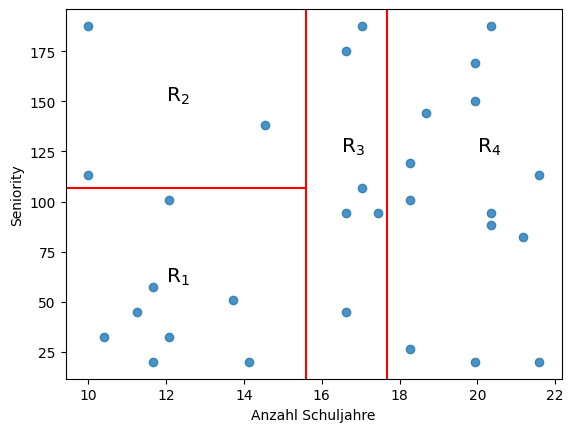

In [6]:
# plot regions in predictor space
params = {"mathtext.default": "regular"}
plt.rcParams.update(params)
plt.scatter(df["education"], df["seniority"], alpha=0.8)
plt.axvline(x=15.59, color="r", linestyle="-")
plt.axhline(y=106.9, xmax=0.481, color="r", linestyle="-")
plt.axvline(x=17.68, color="r", linestyle="-")
plt.text(x=12, y=60, s="$R_{1}$", fontsize="x-large")
plt.text(x=12, y=150, s="$R_{2}$", fontsize="x-large")
plt.text(x=16.5, y=125, s="$R_{3}$", fontsize="x-large")
plt.text(x=20, y=125, s="$R_{4}$", fontsize="x-large")
plt.xlabel("Anzahl Schuljahre")
plt.ylabel("Seniority")
plt.show()

Für jede der vier Regionen können wir den Mittelwert des Einkommens berechnen. Diese sind, wie oben beschrieben, in den Blättern des Baumes angeführt.
Die vier Regionen (auch **Endknoten** oder **Blätter** genannt)  $R_{1}$ - $R_{4}$ unterteilen den Prädiktorenraum nach folgenden Eigenschaften:

- $R_{1} = \{X | education < 15.59, seniority < 106.90\}$ &rarr; Personen mit weniger als 15.59 Schuljahren und einer Seniority von höchstens 106.9
- $R_{2} = \{X | education < 15.59, seniority > 106.90\}$ &rarr; Personen mit weniger als 15.59 Schuljahren und einer Seniority von mindestens 106.9
- $R_{3} = \{X | 15.59 < education < 17.86 \}$ &rarr; Personen zwischen 15.59 und 17.86 Schuljahren
- $R_{4} = \{X | education > 17.86 \}$ &rarr; Personen mit mehr als 17.86 Schuljahren

Anhand der Regionen und der Baumstruktur lassen sich Entscheidungsbäume sehr gut in Worten beschrieben und können somit bei komplexen Datensätzen leichter als klassische Regressionsmdelle interpretiert werden.

Die Hauptelemente eines Entscheidungsbaums lasssen sich also wie folgt zusammenfassen:
    
| Baumelement  | Definition  |
|---|---|
|  Blatt/Endknoten | Unterste Ebene des Entscheidungsbaumes nachdem alle Splits vollzogen wurden.  |
|  Interne Knoten | Knoten, die zwischem dem Ursprung und den Blättern liegen. Entlang dieser Knoten wird gesplittet.  |
|  Zweige | Segmente des Baums, welche die Knoten verbinden.  |

Beim betrachten eines Entscheidungsbaumes wird schnell deutlich, dass theoretisch bliebig viele Regionen $R_{n}$ erzeugt werden könnten. Es stellt sich also die Frage wie eine Entscheidungsbaum effizient und möglichst aussagekräftig auf gegebenen Daten erzeugt werden kann. Hierzu sind im Allgemeinen folgende 2 Schritte durchzuführen:

1. Wir teilen den Prädiktorenraum, also die Menge aller möglichen Werte für $X_{1}, X_{2}, ..., X_{j}$ in $J$ distinkte und sich nicht überlappende Regionen $R_{1}, R_{2}, , ..., R_{J}$
2. Für jede Beobachtung, die in die Region $R_{j}$ fällt, machen wir dieselbe Vorhersage anhand des Mittelwerts der Trainingsdaten der entsprechenden Region.

Wie wählen wir aber die Regionen $R_{1}, ..., R_{J}$? 

Hierbei ist die Unterteilung in die obigen vier Regionen eine starke Verienfachung. In der Praxis werden die Regionen so gewählt, dass die **Summe der Fehlerquadrate (SSE)** minimiert wird.

$$SSE = \sum_{j=1}^J\sum_{i \in \mathbb{R}} (y_{i} - \hat y_{R_{j}})^2$$

wobei $\hat y_{R_{j}}$ den Mittelwert der Trainingsbeobachtungen in ther j-ten Region angibt.

Es wird schnell deutlich, dass es in der Praxis keinen Sinn macht jede mögliche Partitionierung in Regionen durchzuführen um am Ende die beste Konfiguration zu wählen. Daher wird der Entscheidungsbaum in der Praxis mit einem *top-down greedy* Verfahren aufgebaut. Dieses Verfahren wird auch als **rekursives binäres Splitting** bezeichnet. Hierbei beginnt man oben am Baum und splitted immer in suzzesive 2 Regionen, wobei der Splitpunkt *s* immer so gewählt wird, dass der Split zur größt möglichen Reduktion im SSE führt. Das Verfahren ist **greedy**, da bei jedem Split des Baumaufbaus immer nur der beste Split zu diesem bestimmten Zeitpunkt definiert wird. Es wird also nicht berücksichtigt ob der Split zum Zeitpunkt $t_{1}$ ein guter Split für den finalen Baum war, der zu einem späteren Zeitpunkt $t_{5}$ entstehen könnte. Dieses Verfahren wird so lange wiederholt, bis ein Stopkriterium erfüllt ist (z.B. weniger als 5 Datenpunkte in einer Region).

Der **Top-Down Greedy Entscheidungsbaum Algorithmus** lässt sich also wie folgt formalisieren:

1. Starte mit dem gesmaten Prädiktorraum und splitte diesen in 2 Regionen unter Selektion des Prädiktors $X_{j}$ und dem Splitpunkt $s$, so dass der Raum in die beiden Regionen $\{X|X_{j} < s\}$ und $\{X|X_{j} \geq s\}$ unterteilt wird und zur größt möglichen Reduktion im SSE führt. Die Notation $\{X|X_{j} < s\}$ bedeutet in diesem Kontext, dass die Region des Prädiktorraums in dem $X_{j}$ einen Wert kleiner $s$ annimmt. Das bedeuet, wir berücksichtigen alle Prädiktoren $X_{1}, ..., X_{p}$ und alle möglichen Werte für den Splitpunkt $s$ für jeden der Prädiktoren. Formal können wir notieren:

    Für jedes $j$ und $s$ definieren wir das Paar an Halbebenen

    $$R_{1}(j, s) = \{X|X_{j} < s\}$$ 
    
    und 
    
    $$R_{2}(j, s) = \{X|X_{j} \geq s\}$$
    
    und wir suchen Werte für $j$ und $s$, welche folgende Gleichung minimieren:
    
    $$\sum_{i: x_{i} \in R_{1}(j,s)} (y_{i} - \hat y_{R_{1}})^2 + \sum_{i: x_{i} \in R_{2}(j,s)} (y_{i} - \hat y_{R_{2}})^2$$


2. Wiederhole dieses Vorgehen für den nächsten Split, wobei der SSE nur für diesen Split zum Zeitpunkt $t_{j}$ minimiert wird.

3. Der Prozess endet sobald ein Stoppkriterium $K$ erreicht ist, wobei $K$ die Anzahl Datenpunkte in einer Region sein kann. Zum Beispiel $K=5$.

4. Sobald die Regionen $R_{1}, ..., R_{J}$ erstellt wurden, wird der Mittelwert zu jeder Beobachtung des Testdatensatzes, die in diese Region fällt, ausgegeben.

### Regressionsbäume in Python

Lassen Sie uns zur Veranschaulichung den soeben beschriebenen Algorithmus in Python implementieren:

Wir werden den Entscheidungsbaum Regressor als Python Klasse implementieren. Details zu objektorientierter Programmierung sind hier nicht entscheidend und können getrost ignoriert werden. Wichtig ist nur, dass wir die Hauptmethoden der Klasse verstehen. Bevor wir mit der Implementierung starten, benötigen wir ein paar Standardfunktionen, die wir der Klasse hinzufügen:

- `__init__()`: wird bei der Instantierung des `MyDecisionTreeRegressor()` Objekts ausgeführt.
- `calculate_sse()` zur Berechnung des SSE
- `get_overall_sse()` zur Berechnung des SSE für beide Hälften des Splits. Dieser overall SSE wird mimiert.

In [7]:
import numpy as np


class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, max_n_leaf_observations=1):
        self.max_depth = max_depth
        self.max_n_leaf_observation = max_n_leaf_observation
        self.tree = None

    def calculate_sse(self, y):
        return np.sum((y - np.mean(y)) ** 2)

    def get_overall_sse(self, left_y, right_y):
        left_sse = calculate_sse(left_y)
        right_sse = calculate_sse(right_y)
        return left_sse + right_sse

Nun erweitern wir die Implementierung um die `fit()` Methode, welche vom Nutzer verwendet werden kann und die interne Methode `fit_tree()`, in welcher die eigentliche rekursive Implementierung steckt. In dieser Methode ist das Ziel, den besten Split zu bestimmen und dieses Vorgehen rekursiv anzuwenden, bis der beste Split gefunden wurde.

In [8]:
import numpy as np


class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, max_n_leaf_observations=1):
        self.max_depth = max_depth
        self.max_n_leaf_observation = max_n_leaf_observation
        self.tree = None

    def calculate_sse(self, y):
        return np.sum((y - np.mean(y)) ** 2)

    def get_overall_sse(self, left_y, right_y):
        left_sse = calculate_sse(left_y)
        right_sse = calculate_sse(right_y)
        return left_sse + right_sse

    def fit_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        unique_y = np.unique(y)

        # Stopkriterien
        if len(unique_y) == self.max_n_leaf_observation:
            return {"value": unique_y[0]}
        if depth == self.max_depth:
            return {"value": np.mean(y)}

            # Greedy algorithm um den beste Split zu finden
            best_split = None
            best_sse = float("inf")

            for feature in range(n_features):
                thresholds = np.unique(X[:, feature])
                for threshold in thresholds:
                    left_indices = X[:, feature] <= threshold
                    right_indices = X[:, feature] > threshold

                    if np.any(left_indices) and np.any(right_indices):
                        left_y = y[left_indices]
                        right_y = y[right_indices]

                        sse = self.get_overall_sse(left_y, right_y)

                        if sse < best_sse:
                            best_sse = sse
                            best_split = {
                                "feature": feature,
                                "threshold": threshold,
                                "left": (X[left_indices], y[left_indices]),
                                "right": (X[right_indices], y[right_indices]),
                            }

            if best_split is None:
                return {"value": np.mean(y)}

            # rekursiver Aufruf der fir Methode
            left_tree = fit_tree(*best_split["left"], depth + 1)
            right_tree = fit_tree(*best_split["right"], depth + 1)

            return {
                "feature": best_split["feature"],
                "threshold": best_split["threshold"],
                "left": left_tree,
                "right": right_tree,
            }

        def fit(self, X, y):
            # wir updaten das Baum Attribut der Klasse als letzen Schritt
            self.tree = fit_tree(X, y, depth=0)

Folgendes ist bei der Implemetierung der `fit()` Methode zu beachten:

- Zunächst werden die Stoppkriterien geprüft
- Dann wird über jedes Feature/Prädiktor iterriert und eine `threshold` S so gesucht, dass der SSE minimiert wird.
- Ist dies erfolgt, dann wird der beste Split als `best_split` Dictionary gesetzt
- Zum Schluss, in der eigentlich vom User aufgerufenen Methode, wird das Attribut `self.tree` der Entscheidungsbaum Klasse gesetzt (hier wird dann zur Laufzeit die rekursive Methode `fit_tree()` aufgerufen), sobald der beste Baum mit den besten Splits gefunden wurde. Die Speicherung in `self.tree` ist nützlich, da wir so den gefundenen Baum in der noch zu implementierenden `predict()` Methode verwenden können.

Lassen Sie uns diese `predict()` Methode als nächstes implementieren. Auch hier splitten wir die Methode wieder in 2 Methoden: Eine, die der User für die gesamten Daten aufruft (`predict()`) und die andere (`predict_sample()`), welche die Implementierung für eine Beobachtung verarbeitet:

In [9]:
import numpy as np


class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, max_n_leaf_observations=1):
        self.max_depth = max_depth
        self.max_n_leaf_observations = max_n_leaf_observations
        self.tree = None

    def calculate_sse(self, y):
        return np.sum((y - np.mean(y)) ** 2)

    def get_overall_sse(self, left_y, right_y):
        left_sse = calculate_sse(left_y)
        right_sse = calculate_sse(right_y)
        return left_sse + right_sse

    def fit_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        unique_y = np.unique(y)

        # Stopkriterien
        if len(unique_y) == self.max_n_leaf_observations:
            return {"value": unique_y[0]}
        if depth == self.max_depth:
            return {"value": np.mean(y)}

            # Greedy algorithm um den beste Split zu finden
            best_split = None
            best_sse = float("inf")

            for feature in range(n_features):
                thresholds = np.unique(X[:, feature])
                for threshold in thresholds:
                    left_indices = X[:, feature] <= threshold
                    right_indices = X[:, feature] > threshold

                    if np.any(left_indices) and np.any(right_indices):
                        left_y = y[left_indices]
                        right_y = y[right_indices]

                        sse = self.get_overall_sse(left_y, right_y)

                        if sse < best_sse:
                            best_sse = sse
                            best_split = {
                                "feature": feature,
                                "threshold": threshold,
                                "left": (X[left_indices], y[left_indices]),
                                "right": (X[right_indices], y[right_indices]),
                            }

            if best_split is None:
                return {"value": np.mean(y)}

            # rekursiver Aufruf der fir Methode
            left_tree = fit_tree(*best_split["left"], depth + 1)
            right_tree = fit_tree(*best_split["right"], depth + 1)

            return {
                "feature": best_split["feature"],
                "threshold": best_split["threshold"],
                "left": left_tree,
                "right": right_tree,
            }

    def fit(self, X, y):
        # wir updaten das Baum Attribut der Klasse als letzen Schritt
        self.tree = self.fit_tree(X, y, depth=self.max_depth)

    def predict_sample(self, x, tree):
        if "value" in tree:
            return tree["value"]
        if x[tree["feature"]] <= tree["threshold"]:
            return predict_sample(x, tree["left"])
        else:
            return predict_sample(x, tree["right"])

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

Es wird deutlich, dass wir den in der `fit()` Methode erzeugten Entscheidungsbaum hier nun nutzen und die darin gespeicherten Splitwerte für jeden Datenpunkt anwenden. Ebenfalls hervorzuheben ist, dass zu Beginn der `predict_sample()` Methode zunächst geprüft wird ob `"value" in tree`. Diese einfache Prüfung geht auf das Setzen des Strings "value" als der Default für die Stopkriterien in der `fit()` Methode zurück. 

Hier ein Beispiellauf des soeben implementierten Models:

In [10]:
# Beispieldaten
X = np.array([[2, 3], [10, 15], [6, 8], [1, 2], [7, 10]])
y = np.array([1, 4, 2, 1, 3])

# Instantierung des Models nud Modelfitting
model = MyDecisionTreeRegressor(max_depth=3, max_n_leaf_observations=5)
model.fit(X, y)

# Nach Modelfit rufen wir die Vorhersagemethode auf
test_data = np.array([[1, 14], [2, 12]])
predictions = model.predict(test_data)
print("Predictions:", predictions)

Predictions: [2.2 2.2]


Anhand dieser Implementiernug lassen sich Entscheidungsbäume gut nachvollziehen. Bitte beachten Sie jedoch, dass dies **nur ein Beispiel zur Veranschaulichung** ist und das Ergebnis von professionellen Implementierungen wie in der `scikit-klearn` Bibliothek abweichen kann. Gründe hierfür sind unter anderen folgende:
- sklearn implementiert Entscheidungsbäume effizient und nutzt bessere Algorithmen als unser naives Beispiel (siehe Tree Pruning im nächsten Abschnitt)
- sklearn nutzt dem MSE anstatt des SSE.

Nichts desto trotz können wir aus obigem Beispiel die Grundlagen des Greedy Entscheidungsbaum Algorithmus verstehen.
Im nächsten Abschnitt werden wir auf eine mögliche Erweiterung hinweisen (Tree Pruning), die in professionellen Implementierungen häufig Anwendung findet und zu weit aus besseren Ergebnissen führt als die einfache Greedy Entscheidungsbaum Variante.

## Tree Pruning

Das soeben beschriebene Vorgehen kann sehr gute Vorhersagen auf dem Trainigsdatensatz liefern, kann aber dazu neigen auf zuvor ungesehenen Validierungs- oder Testdatensätzen schlechte Vorhersagen zu liefern. Dies liegt daran, dass der greedy Ansatz dazu neigt möglichst goße Entscheidugsbäume aufzuspannen und somit die Trainingsadten zu **overfitten**. Ein kleinerer Baum, der weniger Spits und somit weniger Regionen $R_{1} ... R_{n}$ enthällt, kann aufgrund geringerer Varianz zu besseren generalisierten Vorhersagen auf den Testdaten führen. 

Eine Lösung des Problems könnte sein, weniger Splits beim Aufbau des Entscheidungsbaumes zuzulassen, indem man eine Grenze für die relative Verbesserung des SSE vorgibt und somit ab einer bestimmten marginalen Verbessernug des SEE keine weiteren Splits zulässt. Nachteil dieses Verfahrens ist jedoch, dass eventuell "bedeutungslose" Splits zu Beginn des Aufbaus auftreten könnten, wodurch eine spätere Verbesserung des SSE, durch einen weiteren Split, der theoretisch gut wäre, aber aufgrund des Abbruchkriteriums nicht mehr zustande kommt, verhindert wird.
Daher zieht man es in der Praxis vor, einen sehr **tiefen Entscheidungsbaum** zu generieren und diesen dann zu **trimmen** (zurück schneiden) um einen **Sub-Baum** zu erhalten.

Das hierfür verwendete Verfahren wird in der Literatur auch **Cost-complexity pruning** oder **weakest link pruning** genannt und kann wie folgt beschrieben werden:

1. Baue eine Entscheidungsbaum durch einaches binäres Splitten auf, bis ein Stoppkriterium (z.B. N<5) erreicht ist (siehe **Top-Down Greedy Entscheidungsbaum Algorithmus**). Dieser tiefe Baum wird als $T_{0}$ bezeichnet.

2. Wende **Cost-complexity pruning** auf den tiefen Entscheidungsbaum an um eine Sequenz an Subbäumen $T$ in Abhängigkeit eines Skalierungsparameters $\alpha$ zu erhalten. Zu jedem $\alpha$ gehört also ein Subbaum $T$, sodass gilt:

 $$\sum_{m=1}^{\mid T\mid} \sum_{i: x_{i} \in R_{m}} (y_{i} - \hat y_{R_{m}})^2 + \alpha \mid T \mid$$,
 
 wobei $\mid T \mid$ das Minimum der Anzahl Blätter von $T$ darstellt, $R_{m}$ die Region des Prädiktorraums, die zum $m$-ten Blatt gehört, und $y_{R_{m}})$ stellt den vorhergesagten Wert dar, der zur Region $R_{m}$ gehört, also der Mittelwert der Trainingsdaten in dieser Region.
 
Daraus folgt: 
 
Wenn $\alpha = 0$, dann ist Subbaum $T = T_{0}$.

Wenn $\alpha > 0$, dann wird $\mid T \mid$ kleiner und folglich auch der Subbaum $T$. Dies erlaubt ein kontrolliertes **Trimmen** (engl. pruning) des Baumes in Abhängigkeit von $\alpha$ unter Nutzung von Validierungsdaten.

3. Nutze Krossvalidierung um $\alpha$ zu wählen, sodass der mittlere Vorhersagefehler über alle Validierungssätze minimal ist.

4. Kehre zum Subbaum aus Schritt 2 zurück, der zu dem gewählten $\alpha$ gehört.


#### Regressionsbäume in Python und Scikit-Learn

Im folgenden können wir so einen Entscheidungbaum auf den **Hitters-Datenatz** anwenden. Dieser Datensatz enthällt Features von Baseball Spielern anhand derer das Gehalt der Spieler vorhergesagt werden soll. Wir verwenden bei der Implementierung `sckit-learn`Bibliothek. Das Beispiel soll zeigen, wie der Testfehler nach einer bestimmten Anzahl an Blättern nicht mehr besser wird:

Laden wir zunächst die Daten:

In [11]:
data = pd.read_csv("../../data/hitters.csv")
data = data.dropna()
data.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Als nächstes dummy-enkodieren wir die kategorialen Variablen und standartisieren alle metrischen Prädiktoren:

In [12]:
# Enkodierung der Daten
data = pd.get_dummies(data, drop_first=True)

#  Features und Target definieren
X_df = data.drop("Salary", axis=1)
y_df = data["Salary"]
X = X_df.values
y = y_df.values

# Standardtisierung der Daten
scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

Im letzten Schritt können wir nun die Daten in **Trainings-, Validierungs-, und Testdaten** aufteilen und den Entscheidungsbaum trainieren.

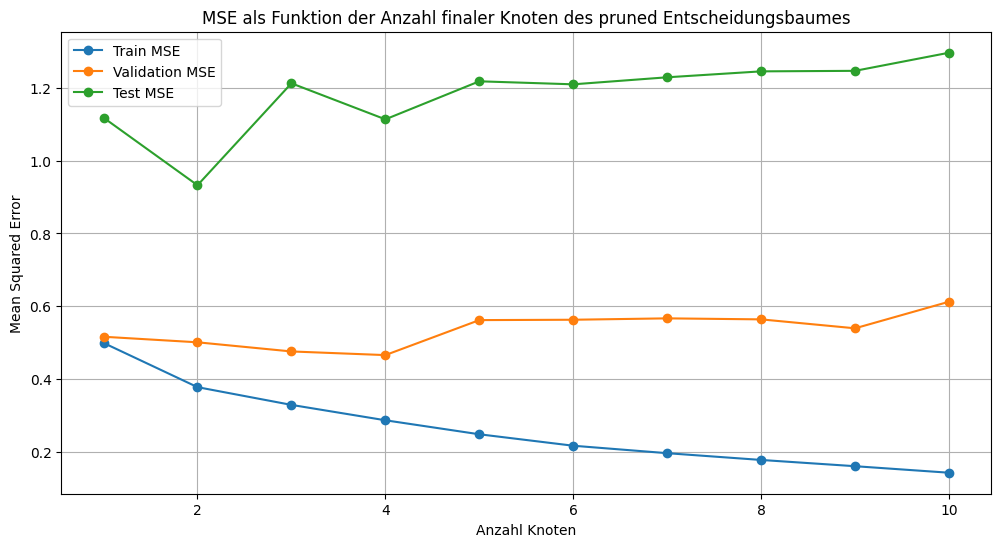

In [13]:
# Splitten der Daten in train, validatio und test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standardized, y_standardized, test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Leere Listen zur Speicherung der Ergebnisse
train_mse = []
valid_mse = []
test_mse = []

# Fitten der "pruned" Entscheidungsbäume
for n_nodes in range(2, 12):
    tree = DecisionTreeRegressor(max_leaf_nodes=n_nodes, random_state=42)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_valid_pred = tree.predict(X_valid)
    y_test_pred = tree.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_train_pred))
    valid_mse.append(mean_squared_error(y_valid, y_valid_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# Erzeuge Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), train_mse, label="Train MSE", marker="o")
plt.plot(range(1, 11), valid_mse, label="Validation MSE", marker="o")
plt.plot(range(1, 11), test_mse, label="Test MSE", marker="o")
plt.xlabel("Anzahl Knoten")
plt.ylabel("Mean Squared Error")
plt.title("MSE als Funktion der Anzahl finaler Knoten des pruned Entscheidungsbaumes")
plt.legend()
plt.grid(True)
plt.show()

In dem obigen Plot sehen wir, dass **Pruning** durchaus Sinn macht, da zu tiefe Bäume zu Overfitting neigen: Der Entscheidungsbaum beschreibt die Trainingsdaten sehr gut, generalisiert aber nicht auf das Validierungs- und Test-Set der Daten. Nach 4-5 Knoten im Baum reduziert sich zwar der Fehler (in unserem Beispiel der Mean-Squared-Error (MSE)) auf den Trainingsdaten, jedoch nicht auf den Testdaten.

## Klassifikations-Bäume

**Klassifikationsbäume** sind Regressionsbäumen sehr ähnlich, mit dem Unterschied, das hier eine kategoriale Variable vorhergsagt wird und nicht eine intervall skalierte oder metrische Variable. Das bedeutet, dass bei der Vorhersage nicht der Mittelwert, der zu der Region und assozierten Blättern des Entscheidungsbaumes gehörenden Beobachtungen zurück geliefert wird, sondern die am **häufigsten auftretende Klasse in den Trainingsdaten** der jeweiligen Region.

Es wird somit auch schnell deutlich, dass wir für Klassifikationsbäume den SSE nicht mehr verwenden können. Anstelle des SSE kommt hier die **Klassifikations-Fehlerrate** zum Einsatz. Diese defniert sich als der Anteil an Trainingsdaten in einer bestimmten Region $R_{n}$, die nicht zur häufigsten Klasse dieser Region gehören.

Formal können wir dies wie folgt schreiben:

$$
E = 1 - \max_{k}(\hat p_{mk})
$$


$\hat p_{mk}$ steht in dieser Gleichung also für den Anteil der Trainingdaten oder Traininsgbeobachtungen, die der m-ten Region der k-ten Klasse angehören.

In der Praxis hat sich herausgestellt, das dieser Klassifikationsfehler nicht sensitiv genug ist um Klassifikationsbäume aufzubauen. Daher kommen in der Praxis zwei bessere Maße zum Einsatz:

- der **Gini Index**
- das Maß der **Cross-Entropy**

Der <a href="https://en.wikipedia.org/wiki/Gini_coefficient">Gini-Index</a> ist wie folgt definiert:

$$
G = \sum_{k=1}^K \hat p_{mk} (1-\hat p_{mk})
$$

Eine Alternative zum Gini Index ist die <a href="https://en.wikipedia.org/wiki/Cross-entropy">Cross-Entropy</a>. Sie ist wie folgt definiert:

$$
D = - \sum_{k=1}^K \hat p_{mk} \log{p_{mk}},
$$

da $0 \leq \hat p_{mk} \leq 1$, folgt dass $0 \leq -\hat p_{mk} \log{p_{mk}}$. Die Cross-Entropy D nimmt also nahe null an wenn die $\hat p_{mk}$ der Entscheidungsbäume nahe 0 oder exakt 0 sind. Daher nimmt die Cross-Entropy, analog dem Gini-Index kleinere Werte annimmt, wenn der m-te Knoten des Baumes "pur" ist, also größtenteils Beobachtugen nur einer Klasse enthällt.

### Klassifikationsbäume in Python

Lassen Sie uns analog den Regressions-Bäumen auch einen einfachen Klassifikatoinsbaum in Python implementieren.

Zunächste benötigen wir die soeben erläuterten Funktionen zur Berechnung des Gini-Index (wir werden diese der Einfachhalt halber verwenden), sowie ein paar Hilfsfunktioen zur Bestimmung der Anzahl Labels. Folgende Methoden fügen wir unserer Klasse `MyDecisionTreeClassifier` zunächst hinzu:

- `__init__()`: wird bei der Instantierung des `MyDecisionTreeClassifier()` Objekts ausgeführt.
- `calculate_gini()` und `gini_impurity()`: berechnen den Gini-Index und die "purheit" an einem bestimmten Knoten.
- `count_labels()` und `most_common_label()`: zählen Labels und geben das häufigste Label zurück.

In [14]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
        self.n_features = None

    def calculate_gini(self, left_y, right_y):
        left_impurity = self.gini_impurity(left_y)
        right_impurity = self.gini_impurity(right_y)
        total_impurity = (
            len(left_y) * left_impurity + len(right_y) * right_impurity
        ) / (len(left_y) + len(right_y))
        return total_impurity

    def gini_impurity(self, y):
        counts = self.count_labels(y)
        impurity = 1 - sum((count / len(y)) ** 2 for count in counts.values())
        return impurity

    def count_labels(self, y):
        counts = {}
        for label in y:
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        return counts

    def most_common_label(self, y):
        counts = self.count_labels(y)
        most_common = max(counts.items(), key=lambda item: item[1])
        return most_common[0]

Nun erweitern wir die Implementierung um die Methode `grow_tree()`, welche den Baum aufspannt, sowie die Methode `best_split()`, die den besten Split bestimmt und diesen zusammen mit den besten Features zurück gibt. Die `grow_tree()` Methode wird final in der `fit()` Methode aufgerufen, welche auf vom Endnutzer aufgerufen wird:

In [15]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
        self.n_features = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self.grow_tree(X, y, 0)

    def grow_tree(self, X, y, depth):
        # Prüfe ob alle Label identisch sind
        if len(set(y)) == 1:
            return y[0]
        if self.max_depth is not None and depth >= self.max_depth:
            return self.most_common_label(y)

        # Finde den besten Split
        best_feature, best_threshold = self.best_split(X, y)
        if best_feature is None:
            return self.most_common_label(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self.grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.grow_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_subtree, right_subtree)

    def best_split(self, X, y):
        best_gini = float("inf")
        best_feature = None
        best_threshold = None

        for feature in range(self.n_features):
            thresholds = set(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if len(set(y[left_indices])) == 1 and len(set(y[right_indices])) == 1:
                    continue

                gini = self.calculate_gini(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_gini(self, left_y, right_y):
        left_impurity = self.gini_impurity(left_y)
        right_impurity = self.gini_impurity(right_y)
        total_impurity = (
            len(left_y) * left_impurity + len(right_y) * right_impurity
        ) / (len(left_y) + len(right_y))
        return total_impurity

    def gini_impurity(self, y):
        counts = self.count_labels(y)
        impurity = 1 - sum((count / len(y)) ** 2 for count in counts.values())
        return impurity

    def count_labels(self, y):
        counts = {}
        for label in y:
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        return counts

    def most_common_label(self, y):
        counts = self.count_labels(y)
        most_common = max(counts.items(), key=lambda item: item[1])
        return most_common[0]

Zuletzt fügen wir noch die vom Nutzer verwendete Methode `predict()` hinzu, welche intern die Methode `predict_sample()` verwendet:

In [16]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
        self.n_features = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self.grow_tree(X, y, self.max_depth)

    def grow_tree(self, X, y, depth):
        # Prüfe ob alle Label identisch sind
        if len(set(y)) == 1:
            return y[0]
        if self.max_depth is not None and depth >= self.max_depth:
            return self.most_common_label(y)

        # Finde den besten Split
        best_feature, best_threshold = self.best_split(X, y)
        if best_feature is None:
            return self.most_common_label(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self.grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.grow_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_subtree, right_subtree)

    def best_split(self, X, y):
        best_gini = float("inf")
        best_feature = None
        best_threshold = None

        for feature in range(self.n_features):
            thresholds = set(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if len(set(y[left_indices])) == 1 and len(set(y[right_indices])) == 1:
                    continue

                gini = self.calculate_gini(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def calculate_gini(self, left_y, right_y):
        left_impurity = self.gini_impurity(left_y)
        right_impurity = self.gini_impurity(right_y)
        total_impurity = (
            len(left_y) * left_impurity + len(right_y) * right_impurity
        ) / (len(left_y) + len(right_y))
        return total_impurity

    def gini_impurity(self, y):
        counts = self.count_labels(y)
        impurity = 1 - sum((count / len(y)) ** 2 for count in counts.values())
        return impurity

    def count_labels(self, y):
        counts = {}
        for label in y:
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        return counts

    def most_common_label(self, y):
        counts = self.count_labels(y)
        most_common = max(counts.items(), key=lambda item: item[1])
        return most_common[0]

    def predict(self, X):
        predictions = []
        for sample in X:
            predictions.append(self.predict_sample(sample, self.tree))
        return np.array(predictions)

    def predict_sample(self, sample, node):
        if isinstance(node, tuple):
            feature, threshold, left_subtree, right_subtree = node
            if sample[feature] <= threshold:
                return self.predict_sample(sample, left_subtree)
            else:
                return self.predict_sample(sample, right_subtree)
        else:
            return node

Folgende Punkte sind zur Implementierung hervorzuheben:

- die Methode `grow_tree()` wird rekursiv aufgerufen, sodass sobald ein Split generiert wurde an diesem Knoten erneut ein Entscheidungsbaum der Tiefe 1 generiert wird. Daraufhin wird beim nächsten rekursiven Aufruf die Tiefe `depth` um 1 inkrementiert. Dies geschieht so lange bis ein Abbruchkriterium erfüllt ist und es wird das Tuple `(best_feature, best_threshold, left_subtree, right_subtree)` zurückgeliefert.
- die Methode `best_split()` nutzt den Gini-Index um den besten Splitpunkt zu liefern. Der einfachhalt halber wird hier auch das beste feature ebenso zurück geliefert: `best_feature, best_threshold`.
- in der Methode `fit()` ist zu sehen, wie das Attribut `self.tree` der Klasse gesetzt wird, sobald der Klassifikationsbaum vollständig rekursiv generiert wurde. Dieses Attribut wird beim Aufruf von `predict()` dann später verwendet.

Auch bei dieser Implementierung ist hervorzuheben, dass es sich nur um ein **anschauliches Beispiel** handelt, anhend dessen wir Klassifikationsbäume besser verstehen können.

Hier ein Beispiellauf des eben implementierten Models:

In [17]:
# Beispiel
X = np.array([[2, 3], [1, 1], [4, 5], [3, 4], [5, 6]])
y = np.array([0, 0, 1, 1, 1])

# Instantierung des Klassifikators
clf = MyDecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

# Vorhersage auf Test-Daten
predictions = clf.predict(X)
print(f"Predictions: {predictions}")

Predictions: [1 1 1 1 1]


#### Klassifikationsbäume in Python und Scikit-Learn

Unter Verwendung der Bibliothek `scikit-learn` können wir auch für Klassifikationsbäume eine Anwendungsbeispiel betrachten. Wir nehmen hierzu den **Hurricanes** Datensatz, der Ihnen schon aus dem Kapitel zur logistischen Regression bekannt ist, und wenden den in `scikit-learn` zur Verfügung stehenden `DecissionTreeClassifier()` an. Lassen Sie uns zunächst die Daten laden:

In [18]:
hurricanes = pd.read_excel("../../data/hurricanes.xlsx", index_col=0)
hurricanes.head(5)

,Number,Name,Year,Type,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
RowNames,,,,,,,,,,,
1,430,NOTNAMED,1944,1,30.2,-76.1,32.1,-74.8,35.1,-69.2,80
2,432,NOTNAMED,1944,0,25.6,-74.9,31.0,-78.1,32.6,-78.2,80
3,433,NOTNAMED,1944,0,14.2,-65.2,16.6,-72.2,20.6,-88.5,105
4,436,NOTNAMED,1944,0,20.8,-58.0,26.3,-72.3,42.1,-71.5,120
5,437,NOTNAMED,1944,0,20.0,-84.2,20.6,-84.9,19.1,-93.9,70


Wir werden versuchen die binäre Antwortvariable `Origins` anhand der Prädiktorvariablen `FirstLat` vorherzusagen.

In [19]:
# Benamung der Origin
hurricanes["Origins"] = hurricanes["Type"].replace(
    {0: "tropisch", 1: "aussertropisch", 3: "aussertropisch"}
)
# Erstellung von X und y Datensätzen
X = hurricanes["FirstLat"].values
X = sm.add_constant(X)
y = hurricanes["Origins"].replace({"tropisch": 0, "aussertropisch": 1}).values

/tmp/ipykernel_21123/1118630555.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [20]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Fitten das Klassifikators an die Trainingsdaten
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

Nachdem das Modell an die Trainingsdaten gefitted wurde, können wir durch Aufruf der `predict()` Methode Vorhersagen für die Klasse erhalten.

In [21]:
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0])

Abschliessend können wir, die vom Modell vorhergesagten Werte, mit den echten Werten im Testdatensatz vergleich um die Performanz des Modells zu evaluieren. Dies können wir anhand der **Accuracy** des Models machen.

Diese ist definert als

$$
\text{Accuracy} =
\frac{\text{korrekte Klassifiziernugen}}{\text{gesamte Klassifizierungen}}
$$  

In `scikit-learn` lässt sich die Accuracy wie folgt berechnen:

In [22]:
accuracy_score(y_test, y_pred)

0.8235294117647058

Viel genauer sehen wir jedoch, die korrekt klassifizierten Beobachtungen und Missklassifizierungen anhand einer **Konfusionsmatrix**. Bei der <a href="https://en.wikipedia.org/wiki/Confusion_matrix">Konfusionsmatrix</a> werden die relativen Häufigkeiten **korrekter und inkorrekter Vorhersagen** der vom Modell vorhergesaten Werte und echten Werte gegeneinander in einer Matrix geplotted.

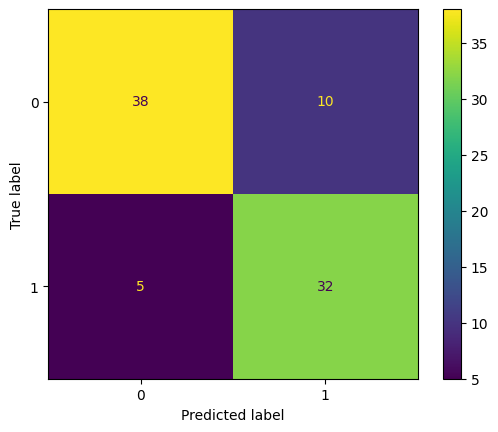

In [23]:
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[0, 1]
)

cm_display.plot()
plt.show()

Wir sehen also, das unser Modell ganz gute Vorhersagen liefert, da die meisten Beobachtungen auf der Hauptdiagonalen liegen.

## Entscheidungsbäume vs. Lineare Modelle

Regressions- und Klassifikationsbäume sind eine fundamental andere Herangehensweise an ein Machine Learning Problem im Vergleich zu klassischen Verfahren wie die lineare Regression. Wenn wir uns das lineare Regressiosnmodell ansehen, dann kann es wie folgt formalisiert werden:

$$
f(X) = \beta_{0} + \sum_{j=1}^p X_{j}\beta_{j}
$$

Im Gegensatz dazu hat ein Entscheidungsbaum folgende Form:

$$
f(X) = \sum_{m=1}^M c_{m} \cdot 1_{X \in R_{m}}
$$

wobei $R_{1}, ..., R_{M}$ eine Partition des Prädiktorraumes repräsentiert. 

Wenn man sich nun fragt welches der beiden Modelle besser ist, bleibt einem nur festzustellen, dass es auf das Problem ankommt. Wenn der Zusammenhang zwischen den Prädiktoren und der Antwortvariablen gut durch ein lineares Modell aproximiert werden kann, dann wird ein lineares Modell besser als ein Entscheidungsbaum funktionieren. Wenn aber ein non-linearer oder komplexer Zusammenhang zwischen den Prädiktoren und der Antwortvariablen besteht, dann ist ein Entscheidungsbaum besser geeignet. Ein illustratives Beispiel hierzu kann mit folgender Visualisierung gegeben werden:

Text(0, 0.5, 'X 2')

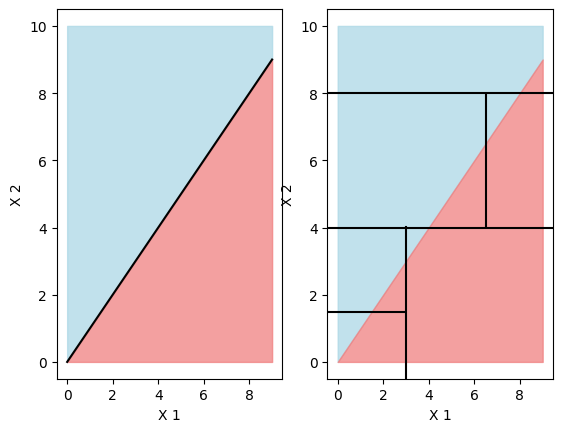

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2)
x = range(10)
# left plot
ax[0].plot(x, color="k")
ax[0].fill_between(x=x, y1=10, y2=x, color="lightblue", interpolate=True, alpha=0.75)
ax[0].fill_between(x=x, y1=x, y2=0, color="lightcoral", interpolate=True, alpha=0.75)
ax[0].set_xlabel("X 1")
ax[0].set_ylabel("X 2")
# right plot
ax[1].axhline(y=1.5, xmax=0.34, color="k", linestyle="-")
ax[1].axvline(x=3, ymax=0.41, color="k", linestyle="-")
ax[1].axhline(y=4, color="k", linestyle="-")
ax[1].axvline(x=6.5, ymin=0.41, ymax=0.77, color="k", linestyle="-")
ax[1].axhline(y=8, color="k", linestyle="-")
ax[1].fill_between(x=x, y1=10, y2=x, color="lightblue", interpolate=True, alpha=0.75)
ax[1].fill_between(x=x, y1=x, y2=0, color="lightcoral", interpolate=True, alpha=0.75)
ax[1].set_xlabel("X 1")
ax[1].set_ylabel("X 2")

Hier ist auf der linken Seite ein linearer Zusammenhang zwischen x1 und x2 farblich kodiert. Dieser Zusammenhang kann somit auch durch ein lineares Modell wie die lineare Regression beschrieben werden. Ein Entscheidungsbaum auf der rechten Seite hat hier Schwierigekiten, da die Anzahl Regionen sehr hoch sein muss um diese linearen Zusammenhang gut zu beschreiben.

Analog lässt sich das Beispiel auch auf nicht-lineare Zusammenhänge zwischen x1 und x2 veranschaulichen (siehe untenstehende Visualisierung). Hier liefert ein lineares Modell auf der linken Seite keine gute Approximierung, jedoch ein nicht-lineares Modell, wie der Entscheidungsbaum, eine sehr gute (siehe rechte Seite).

Text(0, 0.5, 'X 2')

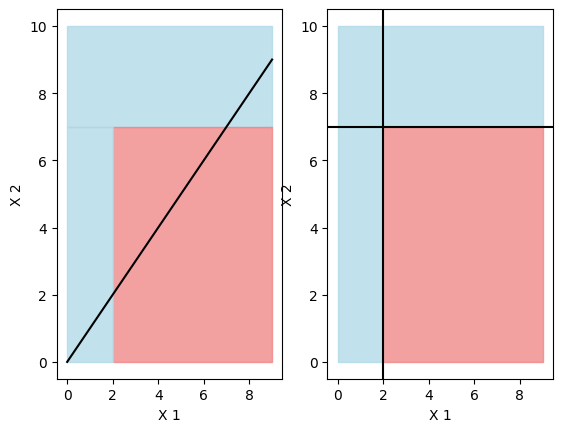

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2)
x = range(10)
# left plot
ax[0].plot(x, color="k")
ax[0].fill_between(x=x, y1=10, y2=7, color="lightblue", interpolate=True, alpha=0.75)
ax[0].fill_between(
    x=range(2, 10), y1=7, y2=0, color="lightcoral", interpolate=True, alpha=0.75
)
ax[0].fill_betweenx(
    y=range(8), x1=2, x2=0, color="lightblue", interpolate=True, alpha=0.75
)
ax[0].set_xlabel("X 1")
ax[0].set_ylabel("X 2")
# right plot
ax[1].fill_between(x=x, y1=10, y2=7, color="lightblue", interpolate=True, alpha=0.75)
ax[1].fill_between(
    x=range(2, 10), y1=7, y2=0, color="lightcoral", interpolate=True, alpha=0.75
)
ax[1].fill_betweenx(
    y=range(8), x1=2, x2=0, color="lightblue", interpolate=True, alpha=0.75
)
ax[1].axvline(x=2, color="k", linestyle="-")
ax[1].axhline(y=7, color="k", linestyle="-")
ax[1].set_xlabel("X 1")
ax[1].set_ylabel("X 2")

## Vor- und Nachteile von Entscheidungsbäumen

Entscheidungsbäume für Regressions- und Klassifikationsprobleme haben einige Vor- und Nachteile gegenüber den Verfahren der vorherigen Kapitel. Diese wollen wir hier auflisten:

**Vorteile:**

- Entscheidungsbäume lassen sich sehr leicht erklären und sind intuitiver als andere Verfahren.
- Manche Menschen sind überzeugt, dass Entscheidungsbäume näher an menschlicher Entscheidungsfindung sind als andere Verfahren.
- Eintscheidungsbäume können grafisch dargestellt werden und sind leicht zu interpretieren. Dies ermöglicht auch Nicht-Experten einen Zugang zu den damit untersuchten Problemen.
- Entscheidungbäume können qualitative Prädiktoren vararbeiten ohne Dummy Variablen einführen zu müssen.

**Nachteile:**

- In manchen Fällen können Entscheidungsbäume nicht die selbe Vorhersagegenauigkeit aufweisen wie andere Verfahren, innsbesondere bei linearen Zusammenhängen.
- Entscheidungsbäume können fragil sein gegenüber kleinen Änderungen in den Daten. Das bedeutet das kleine Änderungen an den Daten relativ große Abweichungen in der Vorhersage produzieren können.

Die soeben angeführten Nachteile lassen sich jedoch durch Erweiterungen der Entscheidungbäume (z.B. durch Bagging, Boosting) kompensieren, was uns auf Entscheidungsbäume angewendet zu *Random Forests* führen wird. Diesen Themen werden wir uns in den nächsten beiden Kapiteln widmen.